In [7]:
import os
import seaborn as sns
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import multiprocess as mp
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import unary_union
import rioxarray as rxr
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from tqdm import tqdm
import geopandas as gpd
from sklearn.metrics import confusion_matrix


REF_ROOT = "/Users/jmccarty/Data/220206_ReTo_carto/template_matching/ref"
DATA_ROOT = "/Users/jmccarty/Data/220206_ReTo_carto/template_matching/tif_files"
SHEETS = ["1092_1990","1111_1988","1132_1989"]
QATM_ROOT = "/Users/jmccarty/GitHub/22spring_templatematching_carto/QATM/notebooks/shape_tests"
RESULTS_PATH = "/Users/jmccarty/GitHub/22spring_templatematching_carto/QATM/notebooks/evaluate"
N_CORES = 6
CHUNK_SIZE = 10000

In [2]:
def generate_mask(raster_path, shape_path, output_path):
    """
    Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file.
    """
    
    #load raster
    
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    
    #Verify crs
    if train_df.crs != src.crs:
        print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_df.crs))
        
        
    #Function that generates the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(~transform * tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly
    
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)

    mask = rasterize(shapes=poly_shp,
                     out_shape=im_size)
    
    #Salve
    mask = mask.astype("uint16")
    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    
    with rasterio.open(output_path, 'w', **bin_mask_meta) as dst:
        dst.write(mask * 255, 1)

In [3]:
# quickly fix the original tif files which have no CRS
# this only needed to be run once

for sheet in SHEETS:
    ref_path = os.path.join(DATA_ROOT, f"LKg_{sheet}.tif")
    r = rasterio.open(ref_path, "r+")
    print(r.read_crs())
    r.crs = rasterio.crs.CRS({"init": "epsg:21781"})
    print(r.read_crs())
    r.close()

EPSG:21781
EPSG:21781
EPSG:21781
EPSG:21781
EPSG:21781
EPSG:21781


In [32]:

# to iterate use the indexer on SHEETS
sheet = SHEETS[2]

ref_shape_path = os.path.join(REF_ROOT,f"LKg_{sheet}",f"wetlands_{sheet}.shp")
ref_shape = gpd.read_file(ref_shape_path)
ref_image_path = os.path.join(DATA_ROOT, f"LKg_{sheet}.tif")
qatm_shape_path = os.path.join(QATM_ROOT,f"LKg_{sheet}_maskshape.geojson")
qatm_shape = gpd.read_file(qatm_shape_path)
output_ref_mask_path = os.path.join(RESULTS_PATH,f"{sheet}_ref_shp_mask.tif")
output_qatm_mask_path = os.path.join(RESULTS_PATH,f"{sheet}_qatm_shp_mask.tif")


# generate mask files for the qatm_shapes
generate_mask(ref_image_path,qatm_shape_path,output_qatm_mask_path)
# generate mask files for the original shapes
generate_mask(ref_image_path,ref_shape_path,output_ref_mask_path)

# load the recently created masks
ref_mask = rxr.open_rasterio(output_ref_mask_path)
ref_mask_nan = ref_mask.where(ref_mask['band']==0,np.nan)  

qatm_mask = rxr.open_rasterio(output_qatm_mask_path)
qatm_mask_nan = qatm_mask.where(qatm_mask['band']==0,np.nan)  


/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_49390/3785567254.py:44: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in row['geometry']:
/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_49390/3785567254.py:44: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in row['geometry']:
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in conversion to CF
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cartography/lib/python3.8/site-packages/pyproj/crs/_cf1x8.py:511: UserWarning: angle from rectified to skew grid parameter lost in co

#### Area Comparison

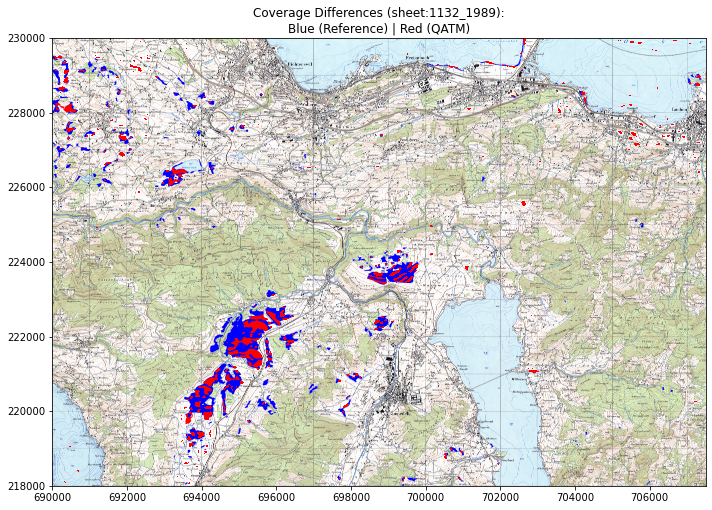

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(rasterio.open(ref_image_path),ax=ax,zorder=0)
ref_shape.plot(ax=ax,zorder=2,color='blue')
qatm_shape.plot(ax=ax,zorder=3,color='red',linewidth=2)


ax.set_title(f"Coverage Differences (sheet:{sheet}):"
             "\n"
             "Blue (Reference) | Red (QATM)") 
plt.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH,f"coverage_map_{sheet}.png"),dpi=144)

#### Display Difference

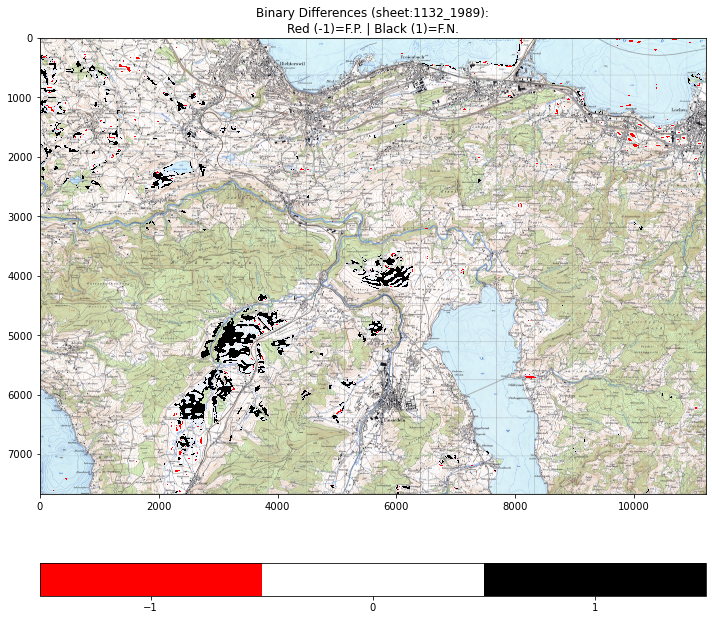

In [34]:
difference = np.ceil(ref_mask[0].values / 255) - np.ceil(qatm_mask[0].values / 255)
difference[difference==0] = np.nan

def resize_image(image, reduce_factor=0.1):
    new_res = (int(image.shape[1]*reduce_factor), int(image.shape[0]*reduce_factor))
    return cv2.resize(image, new_res)

reduction_factor = 0.8

fig, ax = plt.subplots(figsize=(10,10))
cmap = colors.ListedColormap(['red','white', 'black'])
sheet_img = cv2.cvtColor(cv2.imread(ref_image_path), cv2.COLOR_BGR2RGB)
sheet_img_sm = resize_image(sheet_img,reduce_factor=reduction_factor)
ax.imshow(sheet_img_sm,zorder=1)
im = ax.imshow(resize_image(difference,reduce_factor=reduction_factor),zorder=2,
          cmap=cmap, vmin=-1.5, vmax=1.5, interpolation="none")

ax.set_title(f"Binary Differences (sheet:{sheet}):"
             "\n"
             "Red (-1)=F.P. | Black (1)=F.N.") 
bounds=[-2,-1,0,1,2]
fig.colorbar(im, ticks=bounds, orientation="horizontal",fraction=0.05, pad=0.1)
plt.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH,f"difference_map_{sheet}.png"),dpi=144)

#### Absolute Error

13440 indices. Each covers 10000 sqm.
New cell is 80.0 times wider
New cell is 80.0 times taller


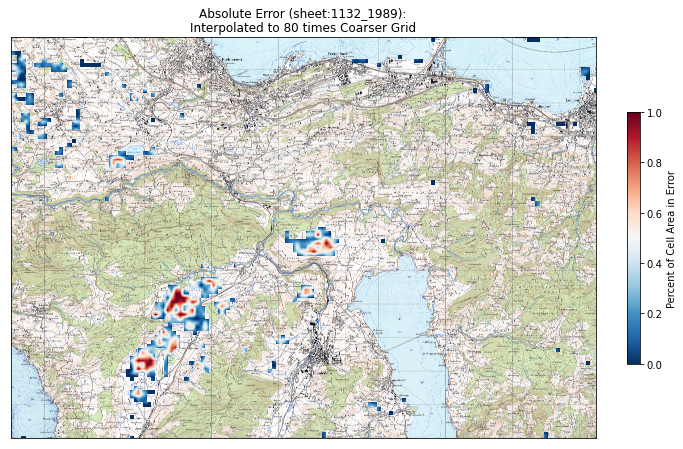

In [35]:
dataset = rasterio.open(output_qatm_mask_path, 'r')
original_cell_size = (dataset.get_transform()[1], abs(dataset.get_transform()[-1]))

cell_mults = []
for cell_mult in range(1,200):
    width = 14000/(1.25*cell_mult)
    height = 9600/(1.25*cell_mult)
    if width.is_integer() and height.is_integer():
        cell_mults.append(cell_mult)
    else:
        pass

cell_mult = 80
# cellulate the arrays
cell_width = int(1.25*cell_mult)
cell_height = int(1.25*cell_mult)
cell_area = int(cell_width * cell_height)

total_width = ref_mask[0].shape[1]
total_height = ref_mask[0].shape[0]

width_indices = np.arange(0,total_width,cell_width)
height_indices = np.arange(0,total_height,cell_height)

indices = []
for i in height_indices:
    for j in width_indices:
        indices.append((i,j))
        
print(f"{len(indices)} indices. Each covers {cell_area} sqm.")
print(f"New cell is {round(cell_width / original_cell_size[0],2)} times wider")
print(f"New cell is {round(cell_height / original_cell_size[1],2)} times taller")

def calc_error(index, sub, cell_width, cell_height):
    i = index[0]
    j = index[1]
    sum_ = np.sum(sub[i:i+cell_height,j:j+cell_width])
    abs_err = round(sum_ / (cell_width*cell_height),3)
    return abs_err
    

sub_ = np.ceil(ref_mask[0].values / 255) - np.ceil(qatm_mask[0].values / 255)

err_ = []
for inx in indices:
    err_.append(calc_error(inx, sub_, cell_width, cell_height))
    
err_arr = np.array(err_).reshape((int(total_height/cell_height), int(total_width/cell_width)))
err_arr[err_arr==0] = np.nan

err_arr_resize = resize_image(err_arr,reduce_factor=9600/err_arr.shape[0])
err_arr_resize[err_arr_resize==0] = np.nan

fig, ax = plt.subplots(figsize=(10,10))

# make a color map of fixed colors
cmap = "RdBu_r"
ax.imshow(sheet_img,zorder=1)
im = ax.imshow(err_arr_resize,
               cmap=cmap, vmin=0, vmax=1, zorder=2, interpolation="none")

ax.set_title(f"Absolute Error (sheet:{sheet}):"
             "\n"
             f"Interpolated to {cell_mult} times Coarser Grid") 
fig.colorbar(im, orientation="vertical",fraction=0.02,label="Percent of Cell Area in Error")

plt.tight_layout()
plt.xticks([])
plt.yticks([])

fig.savefig(os.path.join(RESULTS_PATH,f"error_map_{sheet}.png"),dpi=144)


#### Confusion Matrix

130859673 True Negatives.
289114 False Positives
2201055 False Negatives
1050158 True Positives


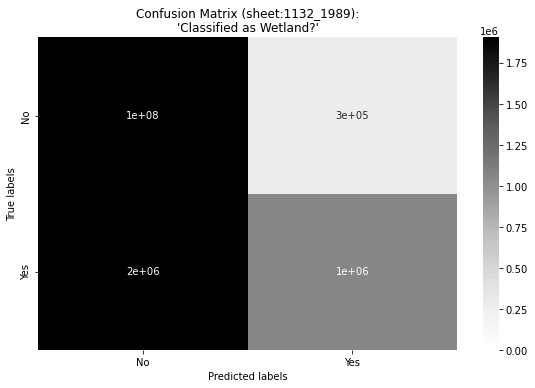

In [36]:
ref_clip = np.clip(ref_mask[0].values,0,1)
qatm_clip = np.clip(qatm_mask[0].values,0,1)
conf_mx = confusion_matrix(ref_clip.flatten(),
                           qatm_clip.flatten())#.argmax(axis=1), .argmax(axis=1))
conf_results = conf_mx.ravel()
print(f"{conf_results[0]} True Negatives.")
print(f"{conf_results[1]} False Positives")
print(f"{conf_results[2]} False Negatives")
print(f"{conf_results[3]} True Positives")

fig,ax= plt.subplots(figsize=(8,5.5))
sns.heatmap(conf_mx, 
            annot=True, 
            fmt='.1g', 
            vmin=0,
            vmax=1904138,
            cmap="Greys",
            ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title(f"Confusion Matrix (sheet:{sheet}):"
             "\n"
             "'Classified as Wetland?'") 
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

plt.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH,f"confusion_matrix_{sheet}.png"),dpi=144)